In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
import tensorflow as tf
from sklearn import metrics
warnings.filterwarnings("ignore")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

2023-05-13 09:01:06.465695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-13 09:01:06.465753: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
df = pd.read_excel('Liquidity-and-interbank-rate.xlsx',
                   sheet_name='LiquiditySeries',
                  skiprows=[0,1,3,4,5,2642]
                  )

In [39]:
df.head()

,Date (Nepali),Date (English),Balance at NRB minus CRR,Prime Rate,Secondary Rate,Overall Rate
0,2069-03-29,2012-07-13,73959.271,NaN,NaN,NaN
1,2069-04-05,2012-07-20,88835.736,NaN,NaN,NaN
2,2069-04-12,2012-07-27,82056.489,NaN,NaN,NaN
3,2069-04-26,2012-08-10,66216.424,NaN,NaN,NaN
4,2069-05-08,2012-08-24,50815.196,NaN,NaN,NaN


In [40]:
df.dtypes

Date (Nepali)                       object
Date (English)              datetime64[ns]
Balance at NRB minus CRR           float64
Prime Rate                          object
Secondary Rate                      object
Overall Rate                        object
dtype: object

In [41]:
df=df.drop(columns=['Date (Nepali)'])

In [42]:
df=df.rename(columns={"Date (English)":"Date"})

In [43]:
df.head()

,Date,Balance at NRB minus CRR,Prime Rate,Secondary Rate,Overall Rate
0,2012-07-13,73959.271,NaN,NaN,NaN
1,2012-07-20,88835.736,NaN,NaN,NaN
2,2012-07-27,82056.489,NaN,NaN,NaN
3,2012-08-10,66216.424,NaN,NaN,NaN
4,2012-08-24,50815.196,NaN,NaN,NaN


In [44]:
df.columns = df.columns.str.replace(' ', '_')

In [45]:
df.head()

,Date,Balance_at_NRB_minus_CRR,Prime_Rate,Secondary_Rate,Overall_Rate
0,2012-07-13,73959.271,NaN,NaN,NaN
1,2012-07-20,88835.736,NaN,NaN,NaN
2,2012-07-27,82056.489,NaN,NaN,NaN
3,2012-08-10,66216.424,NaN,NaN,NaN
4,2012-08-24,50815.196,NaN,NaN,NaN


In [46]:
df['Date']=pd.to_datetime(df['Date'])

In [47]:
df['Date']=df['Date'].dt.date

In [48]:
df['Date']=pd.to_datetime(df['Date'])

In [49]:
df=df.drop(columns=['Prime_Rate', 'Secondary_Rate','Overall_Rate'])

In [50]:
df.head()

,Date,Balance_at_NRB_minus_CRR
0,2012-07-13,73959.271
1,2012-07-20,88835.736
2,2012-07-27,82056.489
3,2012-08-10,66216.424
4,2012-08-24,50815.196


In [34]:
df.columns

Index(['Date', 'Balance_at_NRB_minus_CRR'], dtype='object')

In [96]:
validate = df['Balance_at_NRB_minus_CRR'].tail(15)
# df.drop(df['Balance_at_NRB_minus_CRR'].tail(30).index,inplace=True)

In [63]:
uni_data = df['Balance_at_NRB_minus_CRR']
uni_data.index = df['Date']
uni_data.head()

Date
2012-07-13    73959.271
2012-07-20    88835.736
2012-07-27    82056.489
2012-08-10    66216.424
2012-08-24    50815.196
Name: Balance_at_NRB_minus_CRR, dtype: float64

In [64]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [65]:
def custom_ts_univariate_data_prep(dataset, start, end, window,horizon):
    X = []
    y = []
    start = start+window
    if end is None:
        end=len(dataset)-horizon
    for i in range(start,end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i, i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [82]:
univar_hist_window = 30
horizon = 15
TRAIN_SPLIT = 2500

In [83]:
df.shape

(2606, 2)

In [84]:
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 
                                                          0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, 
                                                      TRAIN_SPLIT, 
                                                      None,
                                                      univar_hist_window,horizon)

In [85]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [86]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(units=50,return_sequences=False),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')

In [87]:
model_path = 'LSTM_Univarient_1.h5'

In [88]:
EVALUATION_INTERVAL = 100
EPOCHS = 50
history = lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
                         validation_data=val_univariate,validation_steps=50,verbose =1,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, patience=10,verbose=1, mode='min'),
                        tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                           save_best_only=True, mode='min',
                                                           verbose=0)])

Epoch 1/50
100/100 [==============================] - 48s 371ms/step - loss: 0.0218 - val_loss: 0.0015
Epoch 2/50
100/100 [==============================] - 34s 341ms/step - loss: 0.0109 - val_loss: 0.0017
Epoch 3/50
100/100 [==============================] - 36s 365ms/step - loss: 0.0094 - val_loss: 0.0021
Epoch 4/50
100/100 [==============================] - 34s 343ms/step - loss: 0.0085 - val_loss: 0.0026
Epoch 5/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0081 - val_loss: 0.0021
Epoch 6/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 7/50
100/100 [==============================] - 34s 343ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 8/50
100/100 [==============================] - 34s 341ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 9/50
100/100 [==============================] - 34s 341ms/step - loss: 0.0067 - val_loss: 0.0015
Epoch 10/50
100/100 [==============================] - 35s 350ms/step - l

In [89]:
Trained_model = tf.keras.models.load_model(model_path)
Trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           40800     
                                                                 
 dropout_2 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                765       
                                                                 
Total params: 71,765
Trainable params: 71,765
Non-trainable params: 0
_________________________________________________________________


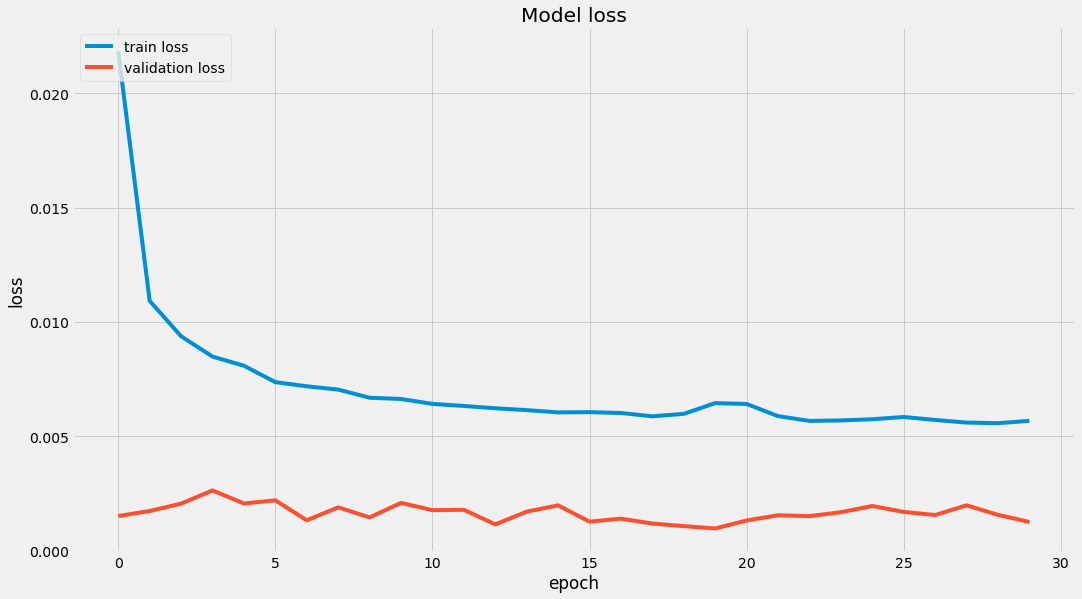

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [91]:
uni = df['Balance_at_NRB_minus_CRR']
validatehori = uni.tail(30)
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
Predicted_results = Trained_model.predict(val_rescaled)
Predicted_results

array([[0.30869874, 0.31821713, 0.3110299 , 0.31028908, 0.30823532,
        0.31980568, 0.31222928, 0.3120308 , 0.3111971 , 0.32349002,
        0.3083245 , 0.2970986 , 0.30535465, 0.30621636, 0.28753075]],
      dtype=float32)

In [93]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)
Predicted_inver_res

array([[3350.9028, 3503.5034, 3388.2764, 3376.3994, 3343.473 , 3528.9712,
        3407.505 , 3404.3228, 3390.9568, 3588.0393, 3344.9026, 3164.927 ,
        3297.2896, 3311.1047, 3011.5334]], dtype=float32)

In [94]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [97]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 22406664.48658466
MAE is : 3967.4377701495046
RMSE is : 4733.567839017907
MAPE is : 46.37209002678054
R2 is : -2.105851128230904

